In [86]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.model_selection import cross_val_score

from scipy import stats
from scipy.stats import norm, skew

train_path = 'https://raw.githubusercontent.com/xdy1019/housing-price-dataset/main/train.csv'
train = pd.read_csv(train_path, index_col=0) 
test_path='https://raw.githubusercontent.com/xdy1019/housing-price-dataset/main/test.csv'
test = pd.read_csv(test_path, index_col=0)
sample_data = 'https://raw.githubusercontent.com/xdy1019/housing-price-dataset/main/sample_submission.csv'

print("train_data: ", train.shape)
print("test_data: ", test.shape)
test.head(5)

train_data:  (1460, 80)
test_data:  (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [81]:
train_numcol = [x for x in train.columns if train.dtypes[x]!= 'object']

train_catcol = [x for x in train.columns if train.dtypes[x]== 'object']
train_num = train[train_numcol]
train_cat = train[train_catcol]
train_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


In [48]:
corr_matrix = train_num.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)
#搞出correlation<0.1的列名，用于后面一起drop

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

In [49]:
X= pd.concat([train.drop("SalePrice", axis = 1),test], axis = 0)
y = train[['SalePrice']]
print(X.shape)
print(y.shape)

(2919, 79)
(1460, 1)


In [50]:
X_numcol = [x for x in X.columns if X.dtypes[x]!= 'object']

X_catcol = [x for x in X.columns if X.dtypes[x]== 'object']
X_num = X[X_numcol]
X_cat = X[X_catcol]
X_cat.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


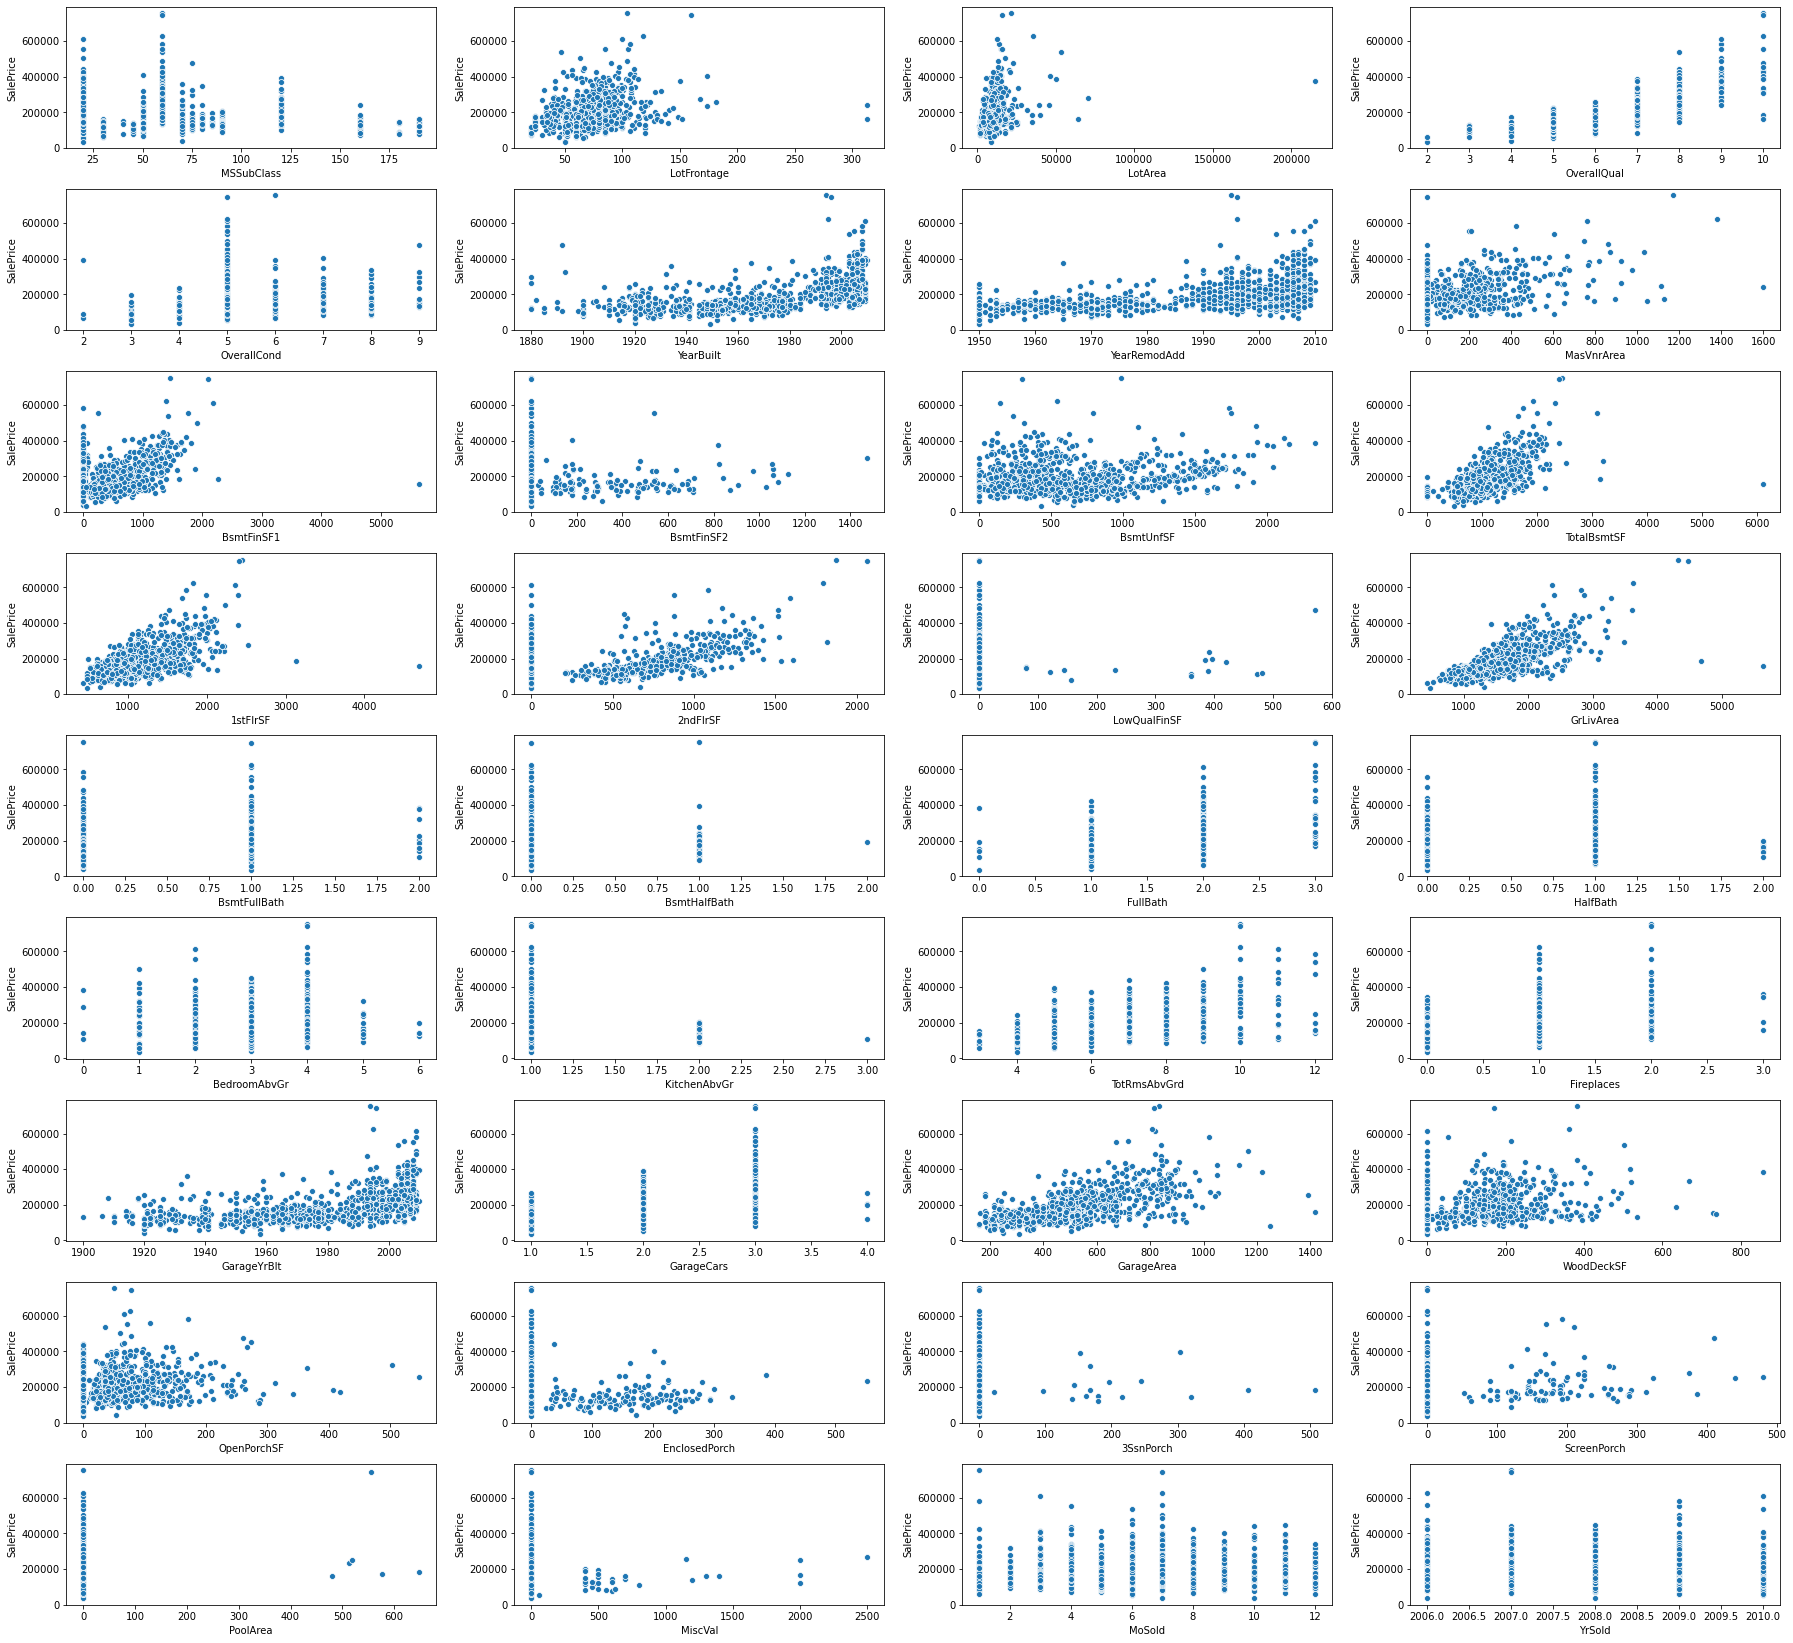

In [51]:
#scatterplot with numerical variables
fig = plt.figure(figsize=(25,25))
for index in range(len(X_num.columns)):
    plt.subplot(10,4,index+1)
    sns.scatterplot(x=train_num.iloc[:,index], y='SalePrice', data=train_num.dropna())
fig.tight_layout(pad=1.0)

In [52]:
#highly correlated numerical features are 1stFlrSF, 2ndFlrSF, BsmtFinSF1, TotalBsmtSF, LotFrontage, GrLivArea, GarageArea

In [53]:
#Multicollinearity

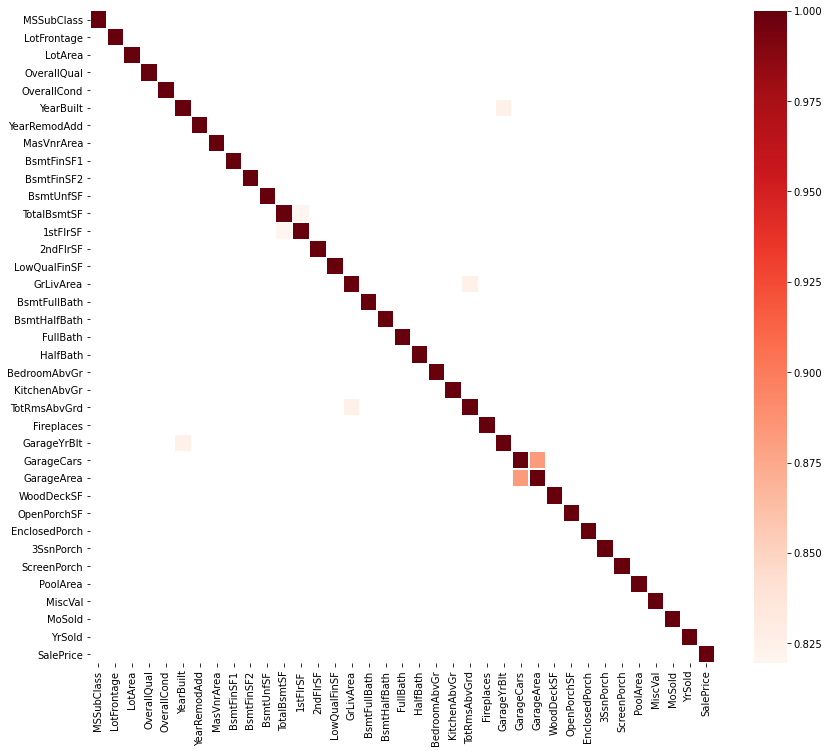

In [54]:
plt.figure(figsize=(14,12))
correlation = train_num.corr()
sns.heatmap(correlation, mask = correlation <0.8, linewidth=0.5, cmap='Reds')

In [55]:
#the highly correlated variables are: GarageArea and GarageCars,TotRmsAbvGrd and GrLivArea, GarageYrBlt and YearBuilt, 1stFlrSF and TotalBsmtSF
X_num = X_num.drop(['GarageYrBlt', '1stFlrSF', 'TotRmsAbvGrd','GarageCars'], axis = 1)


In [56]:
corrcol = list(corr_matrix[abs(corr_matrix['SalePrice'].values) <= 0.15]['SalePrice'].index)
X_num.drop(corrcol, axis = 1, inplace = True)

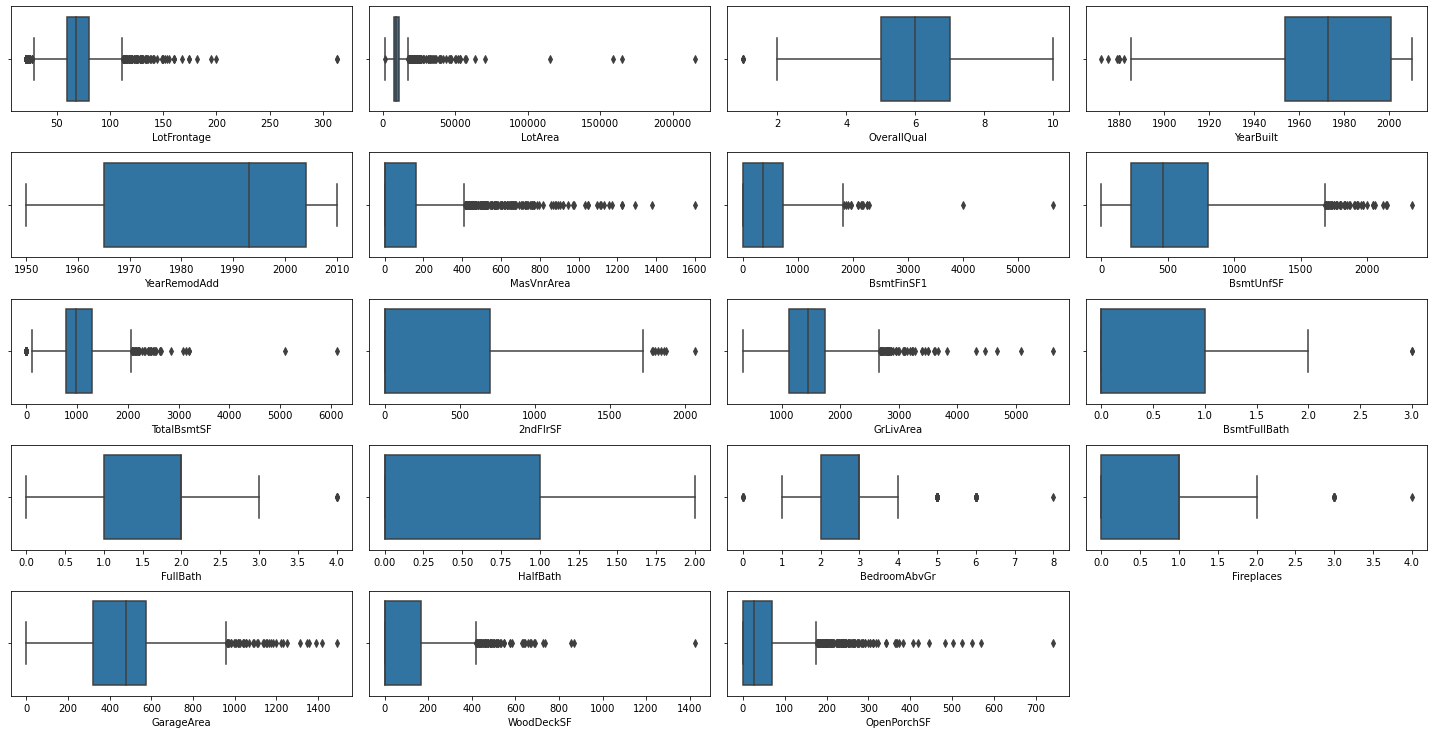

In [57]:
#identify outliers
fig = plt.figure(figsize=(20,20))
for index in range(len(X_num.columns)):
    plt.subplot(10,4,index+1)
    sns.boxplot(data=X_num, x=X_num.iloc[:,index])
fig.tight_layout(pad=1.0)

In [58]:
#drop outliers


In [59]:
#columns with too many missing values
missing_counts = pd.DataFrame(X.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head()
print(missing_counts)

              sum
PoolQC       2909
MiscFeature  2814
Alley        2721
Fence        2348
FireplaceQu  1420


In [60]:
#drop columns with too many missing values
X_cat.drop(['PoolQC','MiscFeature','Alley'], axis=1, inplace=True)

D:\python\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [61]:
overfit_cat = []
for i in X_cat.columns:
    counts = X_cat[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 96:
        overfit_cat.append(i)

overfit_cat = list(overfit_cat)
print(overfit_cat)

['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']


In [62]:
X_cat.drop(overfit_cat, axis=1, inplace = True)

In [63]:
# replace the categorical columns(None has meaning) with NaN with NA
cat = ['GarageType','GarageFinish','BsmtFinType2','BsmtExposure','BsmtFinType1', 
       'GarageCond','GarageQual','BsmtCond','BsmtQual','FireplaceQu','Fence',"KitchenQual",
       "HeatingQC",'ExterQual','ExterCond']

X_cat[cat] = X_cat[cat].fillna("NA")

D:\python\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [64]:
# categorical columns(NaN is meaningless) with NaN
cols_Cat_with_na = X_cat.isnull().sum()
cols_Cat_with_na = cols_Cat_with_na[cols_Cat_with_na>0]
print(cols_Cat_with_na.sort_values(ascending=False))

MasVnrType     24
MSZoning        4
Functional      2
SaleType        1
Electrical      1
Exterior2nd     1
Exterior1st     1
dtype: int64


In [65]:
for column in ['MSZoning','Functional','MasVnrType','SaleType','KitchenQual','Electrical','Exterior2nd','Exterior1st']:
    X_cat[column].fillna(X_cat[column].mode()[0], inplace=True)

D:\python\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [66]:
ordinal_map = {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA':0}
fintype_map = {'GLQ': 6,'ALQ': 5,'BLQ': 4,'Rec': 3,'LwQ': 2,'Unf': 1, 'NA': 0}
expose_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
fence_map = {'GdPrv': 4,'MnPrv': 3,'GdWo': 2, 'MnWw': 1,'NA': 0}

In [67]:
ord_col = ['ExterQual','ExterCond','BsmtQual', 'BsmtCond','HeatingQC','KitchenQual','GarageQual','GarageCond', 'FireplaceQu']
for col in ord_col:
    X_cat[col] = X_cat[col].map(ordinal_map)
    
fin_col = ['BsmtFinType1','BsmtFinType2']
for col in fin_col:
    X_cat[col] = X_cat[col].map(fintype_map)

X_cat['BsmtExposure'] = X_cat['BsmtExposure'].map(expose_map)
X_cat['Fence'] = X_cat['Fence'].map(fence_map)

<ipython-input-67-971f0a91a413>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat[col] = X_cat[col].map(ordinal_map)
<ipython-input-67-971f0a91a413>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat[col] = X_cat[col].map(fintype_map)
<ipython-input-67-971f0a91a413>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [68]:
X_cat = pd.get_dummies(X_cat)

In [69]:
#separate num_train and num_test, fill NAN in numerical columns
num_train = X_num[:1460][:]
num_test = X_num[1460:][:]
cat_train = X_cat[:1460][:]
cat_test = X_cat[1460:][:]
cat_train.head()

,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,FireplaceQu,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,4,3,4,3,1,6,1,5,4,0,...,0,0,0,1,0,0,0,0,1,0
2,3,3,4,3,4,5,1,5,3,3,...,0,0,0,1,0,0,0,0,1,0
3,4,3,4,3,2,6,1,5,4,3,...,0,0,0,1,0,0,0,0,1,0
4,3,3,3,4,1,5,1,4,4,4,...,0,0,0,1,1,0,0,0,0,0
5,4,3,4,3,3,6,1,5,4,3,...,0,0,0,1,0,0,0,0,1,0


In [70]:
num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('std_scaler', StandardScaler()),
])
num_train1 = num_pipeline.fit_transform(num_train)
num_train1 = pd.DataFrame(num_train1, columns=num_train.columns,
index=num_train.index)
num_train1.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF
Id,,,,,,,,,,,,,,,,,,,
1,-0.220875,-0.207142,0.651479,1.050994,0.878668,0.514104,0.575425,-0.944591,-0.459303,1.161852,0.370333,1.107810,0.789741,1.227585,0.163779,-0.951226,0.351000,-0.752176,0.216503
2,0.460320,-0.091886,-0.071836,0.156734,-0.429577,-0.570750,1.171992,-0.641228,0.466465,-0.795163,-0.482512,-0.819964,0.789741,-0.761621,0.163779,0.600495,-0.060731,1.626195,-0.704483
3,-0.084636,0.073480,0.651479,0.984752,0.830215,0.325915,0.092907,-0.301643,-0.313369,1.189351,0.515013,1.107810,0.789741,1.227585,0.163779,0.600495,0.631726,-0.752176,-0.070361
4,-0.447940,-0.096897,0.651479,-1.863632,-0.720298,-0.570750,-0.499274,-0.061670,-0.687324,0.937276,0.383659,1.107810,-1.026041,-0.761621,0.163779,0.600495,0.790804,-0.752176,-0.176048
5,0.641972,0.375148,1.374795,0.951632,0.733308,1.366489,0.463568,-0.174865,0.199680,1.617877,1.299326,1.107810,0.789741,1.227585,1.390023,0.600495,1.698485,0.780197,0.563760


In [71]:
num_test1 = num_pipeline.fit_transform(num_test)
num_test1 = pd.DataFrame(num_test1, columns=num_test.columns,
index=num_test.index)
num_test1.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF
Id,,,,,,,,,,,,,,,,,,,
1461,0.567330,0.363929,-0.751101,-0.340945,-1.072885,-0.563316,0.063428,-0.650461,-0.370716,-0.775254,-1.215588,-0.818068,-1.028720,-0.751040,-1.029543,-0.898055,1.185921,0.366678,-0.701628
1462,0.615963,0.897861,-0.054877,-0.439695,-1.214908,0.047057,1.063511,-0.339225,0.639230,-0.775254,-0.323539,-0.818068,-1.028720,1.237648,0.175997,-0.898055,-0.741235,2.347867,-0.178826
1463,0.275532,0.809646,-0.751101,0.844059,0.678742,-0.563316,0.773377,-0.954831,-0.266784,0.891944,0.294508,-0.818068,0.773083,1.237648,0.175997,0.647066,0.042537,0.930495,-0.207871
1464,0.470064,0.032064,-0.054877,0.876976,0.678742,-0.450284,0.357958,-0.526882,-0.271303,0.837243,0.243004,-0.818068,0.773083,1.237648,0.175997,0.647066,-0.012788,2.089451,-0.178826
1465,-1.232092,-0.971808,1.337571,0.679475,0.394694,-0.563316,-0.387160,1.059048,0.528520,-0.775254,-0.424487,-0.818068,0.773083,-0.751040,-1.029543,-0.898055,0.153187,-0.729632,0.489198


In [72]:
train1 = pd.concat([num_train1, cat_train], axis = 1)
test1 = pd.concat([num_test1, cat_test], axis = 1)

In [73]:
train1.head()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,-0.220875,-0.207142,0.651479,1.050994,0.878668,0.514104,0.575425,-0.944591,-0.459303,1.161852,...,0,0,0,1,0,0,0,0,1,0
2,0.460320,-0.091886,-0.071836,0.156734,-0.429577,-0.570750,1.171992,-0.641228,0.466465,-0.795163,...,0,0,0,1,0,0,0,0,1,0
3,-0.084636,0.073480,0.651479,0.984752,0.830215,0.325915,0.092907,-0.301643,-0.313369,1.189351,...,0,0,0,1,0,0,0,0,1,0
4,-0.447940,-0.096897,0.651479,-1.863632,-0.720298,-0.570750,-0.499274,-0.061670,-0.687324,0.937276,...,0,0,0,1,1,0,0,0,0,0
5,0.641972,0.375148,1.374795,0.951632,0.733308,1.366489,0.463568,-0.174865,0.199680,1.617877,...,0,0,0,1,0,0,0,0,1,0


In [74]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train1, y, test_size=0.2, random_state=2020)

In [77]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error
housing_predictions1 = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

27982.85199903684

In [79]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(X_train, y_train)
housing_predictions2 = forest_reg.predict(X_train)
forest_mse = mean_squared_error(y_train, housing_predictions2)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

<ipython-input-79-c62f670f666b>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_reg.fit(X_train, y_train)


11288.504089045011

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn import ensemble
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from catboost import CatBoostRegressor

In [ ]:
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror')

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_lst = {
    'learning_rate' : [0.01, 0.1, 0.15, 0.3, 0.5],
    'n_estimators' : [100, 500, 1000, 2000, 3000],
    'max_depth' : [3, 6, 9],
    'min_child_weight' : [1, 5, 10, 20],
    'reg_alpha' : [0.001, 0.01, 0.1],
    'reg_lambda' : [0.001, 0.01, 0.1]
}

xgb_reg = RandomizedSearchCV(estimator = xgb, param_distributions = param_lst,
                              n_iter = 100, scoring = 'neg_root_mean_squared_error',
                              cv = 5)
       
xgb_search = xgb_reg.fit(X_train, y_train)

# XGB with tune hyperparameters
best_param = xgb_search.best_params_
xgb = XGBRegressor(**best_param)